In [57]:
import geopandas as gpd
import rasterio as rio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr

# Read data

## Hazard

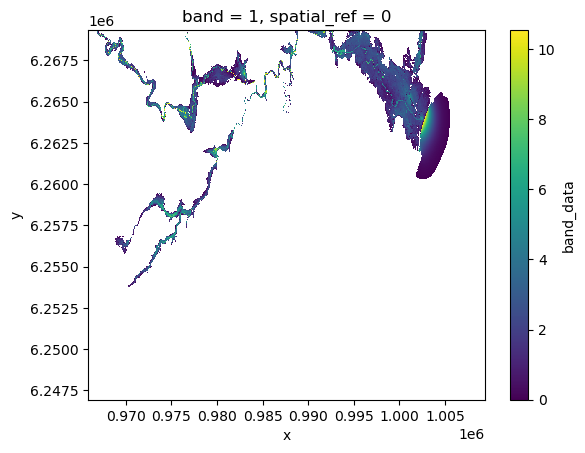

In [70]:
#Read hazard map as an xarray.Dataset
haz = xr.open_dataset('HMaxProba_SudEst_274_100.asc', engine='rasterio').squeeze().band_data
haz.rio.write_crs("EPSG:2154", inplace=True) #Assign CRS
haz.plot()

## Vulnerability

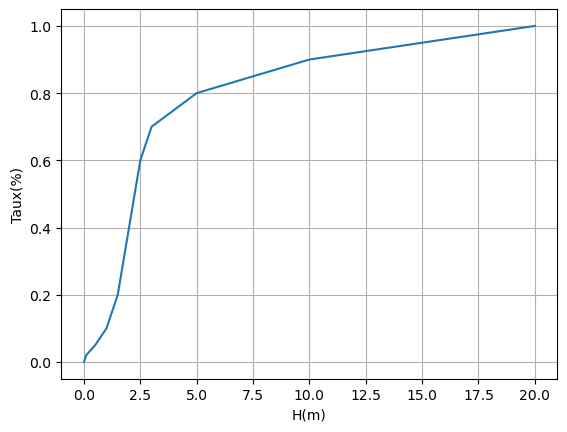

In [71]:
vul = pd.read_csv('CourbeDommages.csv', delimiter=';')
vul['HauteurEau_M'] = vul['HauteurEau_M'].str.replace(',', '.').astype(float)
vul['TauxDestruction'] = vul['TauxDestruction'].str.replace(',', '.').astype(float)
plt.plot(vul['HauteurEau_M'],vul['TauxDestruction' ])
plt.xlabel('H(m)')
plt.ylabel('Taux(%)')
plt.grid(True)
plt.show()

## Exposure

In [74]:
exp = pd.read_csv('Portefeuille.csv', encoding='ISO-8859-1', delimiter=';', index_col='ID')

from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(exp['X'], exp['Y'])]
exp = gpd.GeoDataFrame(exp, geometry=geometry)
# Set the CRS to EPSG:2154
exp.crs = "EPSG:2154" 

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

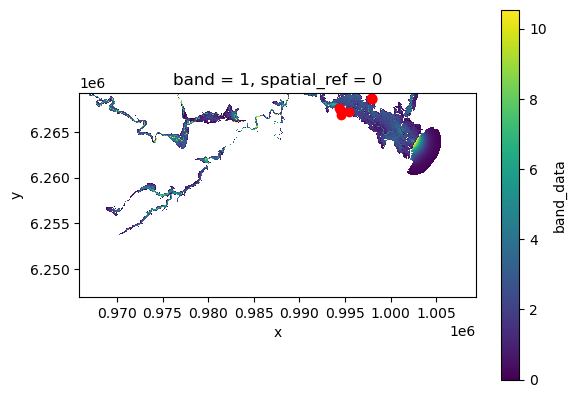

In [75]:
fig, ax = plt.subplots()
haz.plot(ax = ax)
exp.plot(ax = ax, color = 'red')

In [77]:
exp.to_file('Portefeuille.geojson')

In [81]:
# Create an empty list to store the points that fall within the raster
filtered_exp_list = []

# Loop through each point in the GeoDataFrame
for i, row in exp.iterrows():
    # Get the value of the raster at the point location
    val = haz.sel(x=row.geometry.x, y=row.geometry.y, method='nearest').values
    # If the value is not NaN, add the point to the list
    if not np.isnan(val):
        filtered_exp_list.append(row)

# Convert the list to a GeoDataFrame
filtered_exp = gpd.GeoDataFrame(pd.concat(filtered_exp_list, axis=1).T)

# Reset the index of the filtered GeoDataFrame
filtered_exp.reset_index(drop=True, inplace=True)

In [86]:
filtered_exp.crs = "EPSG:2154" 
filtered_exp.to_file('Portefeuille_exposed.geojson')

In [113]:
alea_values = []
for i, row in exp.iterrows():
    alea_values.append(haz.sel(x=row.geometry.x, y=row.geometry.y, method='nearest').values)
exp['alea'] = np.round(alea_values,2)
exp.fillna(0, inplace=True)

/var/folders/th/dv8w1vd93zs5tp16yj9nld_w0000gn/T/ipykernel_77008/2716157183.py:5: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  exp.fillna(0, inplace=True)


In [131]:
exp['taux'] = np.interp(exp['alea'], vul['HauteurEau_M'], vul['TauxDestruction'])

In [132]:
exp['cout'] = np.round(exp['taux'] * exp['ValeurAssuree'],0)

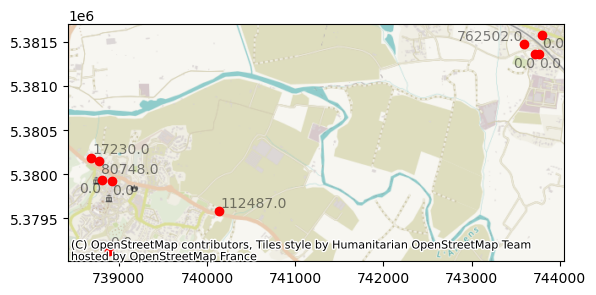

In [153]:
import contextily as ctx
from adjustText import adjust_text

fig, ax = plt.subplots()

# Convert CRS for plotting
exp_3857 = exp.to_crs(epsg=3857)

# Plot points
exp_3857.plot(ax=ax, color='red')

# Prepare labels
texts = []
for x, y, label in zip(exp_3857.geometry.x, exp_3857.geometry.y, exp_3857['cout']):
    #if label != 0.0:  # Ignore null or zero values
    texts.append(ax.text(x, y, label, alpha=0.5))

# Adjust labels to minimize overlaps
adjust_text(texts)

# Add a basemap
ctx.add_basemap(ax)

plt.show()
